CLASSIFICATION BINARIZED FOR EACH CLASS.

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve,precision_recall_curve,auc, average_precision_score, f1_score,accuracy_score,log_loss
from sklearn.preprocessing import label_binarize
from itertools import cycle
import logging
import pandas as pd
from typing import Tuple 
from torch import nn
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from nltk import download
from nltk.corpus import wordnet as wn
import random
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.utils import simple_preprocess
from typing import List, Set
from torch import cuda
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.linear_model import LogisticRegression
import ast


/home/edu/.cache/pypoetry/virtualenvs/zrive-ds-J_lydEot-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# ----------------------------------------------------------------------------------------------------------
## CREATION OF EMBBEDINGS
# ----------------------------------------------------------------------------------------------------------


In [22]:
ROUTE_BINARIZED_NAICS= '../src/data/DF_NAICS_BINARIZED_BUENO_2.csv'
df_naics = pd.read_csv(ROUTE_BINARIZED_NAICS) 
print(df_naics.head())
count_of_ones = df_naics.apply(lambda x: (x == 1).sum())


print(count_of_ones)



import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

# Descargar recursos de NLTK necesarios
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    """Convertir el tag de POS de treebank a wordnet tag"""
    if treebank_tag.startswith('J'):
        return nltk.corpus.wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return nltk.corpus.wordnet.VERB
    elif treebank_tag.startswith('N'):
        return nltk.corpus.wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return nltk.corpus.wordnet.ADV
    else:
        return None

def preprocess_text(text):
    # Tokenizar utilizando NLTK, manteniendo el caso original para el POS tagging
    tokens = word_tokenize(text)
    # POS tagging
    tagged_tokens = pos_tag(tokens)
    # Procesamiento basado en POS
    processed_tokens = []
    for word, tag in tagged_tokens:
        # Aplicar lematización solo si no es un nombre propio o un símbolo
        if not tag.startswith('NNP') and not tag.startswith('NNPS') and word.isalnum():
            wordnet_pos = get_wordnet_pos(tag)  # Obtener el POS compatible con WordNet
            if wordnet_pos:
                word = lemmatizer.lemmatize(word, pos=wordnet_pos)
            else:
                word = lemmatizer.lemmatize(word)
            word = word.lower()  # Convertir a minúsculas después de lematizar
        # Filtrar stopwords y nombres propios, mantener los nombres propios si necesarios
        if word.lower() not in stop_words and word.isalnum():
            processed_tokens.append(word)
    return processed_tokens

def preprocess_dataframe(df, column_name):
    # Aplicar la función de preprocesamiento al DataFrame
    df[column_name] = df[column_name].apply(preprocess_text)
    return df



df_naics_preprocessed = preprocess_dataframe(df_naics, 'BUSINESS_DESCRIPTION')
print(df_naics_preprocessed.head())

count_of_ones = df_naics_preprocessed.apply(lambda x: (x == 1).sum())


print(count_of_ones)



from transformers import DistilBertModel, DistilBertTokenizer
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, dataframe, max_len):
        self.tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
        self.texts = dataframe['BUSINESS_DESCRIPTION'].astype(str).tolist()
        self.max_len = max_len
        self.model = DistilBertModel.from_pretrained("distilbert-base-uncased")

        # Congelar todos los pesos excepto los de la última capa transformer
        for name, param in self.model.named_parameters():
            if 'transformer.layer.5' not in name:  # Asumiendo que la última capa es la número 5
                param.requires_grad = False

        self.naics_columns = dataframe.columns[1:].tolist()
        self.labels = dataframe[self.naics_columns].values

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        inputs = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=self.max_len)
        outputs = self.model(**inputs)
        embeddings = outputs.last_hidden_state[:, 0, :]  # Obtener solo el primer token (CLS token)

        label = self.labels[idx]  # Los labels ya son un array binario para cada fila

        return {
            'embeddings': embeddings.squeeze().detach().cpu().numpy(),
            'labels': label
        }

def create_dataframe(dataset):
    data = []
    for i in range(len(dataset)):
        item = dataset[i]
        row = {'embeddings': item['embeddings']}
        row.update({naics: int(label) for naics, label in zip(dataset.naics_columns, item['labels'])})
        data.append(row)
    df_embeddings = pd.DataFrame(data)
    df_embeddings['embeddings'] = df_embeddings['embeddings'].apply(lambda x: list(x))
    return df_embeddings

dataset = CustomDataset(dataframe=df_naics_preprocessed, max_len=128)
df_embeddings_naics = create_dataframe(dataset)
print(df_embeddings_naics.head())



count_of_ones = df_embeddings_naics.apply(lambda x: (x == 1).sum())


print(count_of_ones)

                                BUSINESS_DESCRIPTION  11  21  22  23  31  32  \
0  License Herbicide, Grass Mowing, Fence Install...   1   0   1   1   0   1   
1  Commercial and military professional aircraft ...   0   0   0   1   0   1   
2  CRL-Lovelady Construction, LLC, provides Gener...   0   0   0   1   0   0   
3  Summerlin Brothers, Inc. established 1996 has ...   0   0   0   1   0   0   
4  Design Build HVAC / General Construction. Faci...   0   0   0   1   0   0   

   33  42  44  ...  53  54  55  56  61  62  71  72  81  92  
0   0   0   0  ...   0   0   0   1   0   0   0   0   0   0  
1   1   1   0  ...   0   0   0   0   0   0   0   0   0   0  
2   0   0   0  ...   0   0   0   0   0   0   0   0   0   0  
3   0   0   0  ...   0   0   0   1   0   0   0   0   0   0  
4   1   1   0  ...   1   1   0   1   0   1   0   0   1   0  

[5 rows x 25 columns]
BUSINESS_DESCRIPTION        0
11                       1162
21                        706
22                        930
23        

[nltk_data] Downloading package punkt to /home/edu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/edu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/edu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/edu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fb1dbc9a4d0>>
Traceback (most recent call last):
  File "/home/edu/.cache/pypoetry/virtualenvs/zrive-ds-J_lydEot-py3.11/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


# ----------------------------------------------------------------------------------------------------------
## LOADING DF EMBBEDINGS AND STARTING WITH MODELS
# ----------------------------------------------------------------------------------------------------------

In [2]:
ROUTE_BINARIZED_NAICS= '../src/data/BUENO_POR_FIN_2.csv'
df_naics = pd.read_csv(ROUTE_BINARIZED_NAICS) 
print(df_naics.head())
count_of_ones = df_naics.apply(lambda x: (x == 1).sum())
print(count_of_ones)

   Unnamed: 0                                         embeddings  11  21  22  \
0           0  [0.3421159, 0.24559289, 0.003188484, -0.454343...   1   0   1   
1           1  [0.37763986, 0.31703675, 0.2015006, -0.1750039...   0   0   0   
2           2  [0.3418419, 0.19359905, 0.4428423, -0.11424164...   0   0   0   
3           3  [0.19853792, 0.14060616, 0.31806898, -0.309403...   0   0   0   
4           4  [0.36185867, 0.218326, 0.29591516, -0.23454015...   0   0   0   

   23  31  32  33  42  ...  53  54  55  56  61  62  71  72  81  92  
0   1   0   1   0   0  ...   0   0   0   1   0   0   0   0   0   0  
1   1   0   1   1   1  ...   0   0   0   0   0   0   0   0   0   0  
2   1   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   0  
3   1   0   0   0   0  ...   0   0   0   1   0   0   0   0   0   0  
4   1   0   0   1   1  ...   1   1   0   1   0   1   0   0   1   0  

[5 rows x 26 columns]
Unnamed: 0        1
embeddings        0
11             1162
21              706
22

## balancear clases

In [3]:
def selectively_reduce_rows(df, threshold=1250, reduction_rate=0.75):
    
    class_counts = df.iloc[:, 2:].apply(pd.value_counts).loc[1]
    classes_to_reduce = class_counts[class_counts > threshold].index.tolist()
    keep_prob = 1 - reduction_rate

    for class_col in classes_to_reduce:
        mask = (df[class_col] == 1)
        random_selection = np.random.rand(mask.sum()) > keep_prob 
        df.loc[mask, class_col] = np.where(random_selection, 0, 1)  

    return df

df_reduced = selectively_reduce_rows(df_naics, threshold=1250, reduction_rate=0.5)
print(df_reduced.head())
count_of_ones = df_naics.apply(lambda x: (x == 1).sum())
print(count_of_ones)

   Unnamed: 0                                         embeddings  11  21  22  \
0           0  [0.3421159, 0.24559289, 0.003188484, -0.454343...   1   0   1   
1           1  [0.37763986, 0.31703675, 0.2015006, -0.1750039...   0   0   0   
2           2  [0.3418419, 0.19359905, 0.4428423, -0.11424164...   0   0   0   
3           3  [0.19853792, 0.14060616, 0.31806898, -0.309403...   0   0   0   
4           4  [0.36185867, 0.218326, 0.29591516, -0.23454015...   0   0   0   

   23  31  32  33  42  ...  53  54  55  56  61  62  71  72  81  92  
0   0   0   1   0   0  ...   0   0   0   1   0   0   0   0   0   0  
1   0   0   1   0   1  ...   0   0   0   0   0   0   0   0   0   0  
2   1   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   0  
3   0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   0  
4   1   0   0   0   1  ...   0   0   0   1   0   1   0   0   0   0  

[5 rows x 26 columns]
Unnamed: 0       1
embeddings       0
11            1162
21             706
22    

/tmp/ipykernel_1166/2643425263.py:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  class_counts = df.iloc[:, 2:].apply(pd.value_counts).loc[1]


/tmp/ipykernel_1166/596625109.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  counts = df_naics[class_columns].apply(pd.value_counts).loc[1].sort_values()


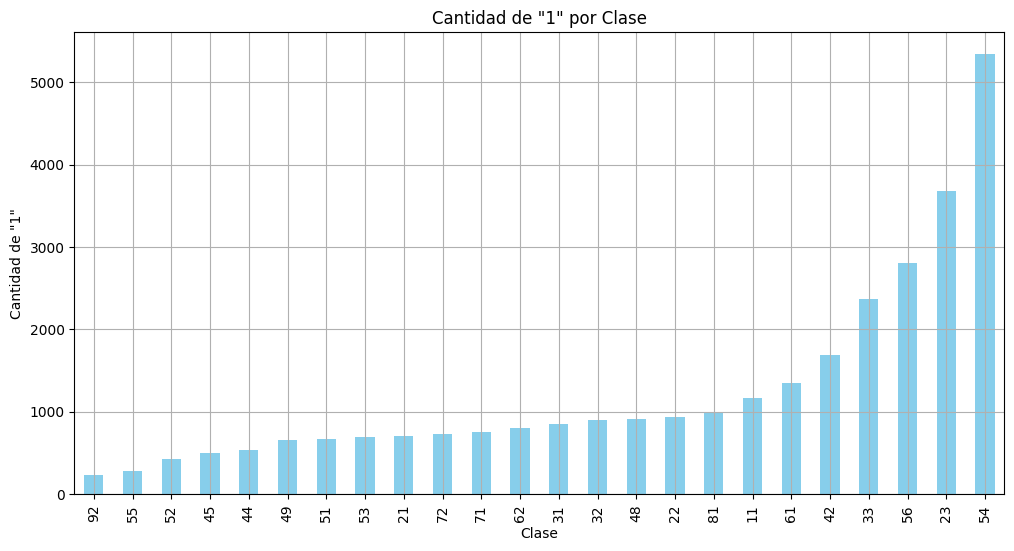

La clase en la posición media del ranking es: 31


In [4]:
class_columns = df_naics.columns[2:]
counts = df_naics[class_columns].apply(pd.value_counts).loc[1].sort_values()

middle_class = counts.index[len(counts) // 2]  


plt.figure(figsize=(12, 6))
counts.sort_values().plot(kind='bar', color='skyblue')
plt.title('Cantidad de "1" por Clase')
plt.xlabel('Clase')
plt.ylabel('Cantidad de "1"')
plt.grid(True)
plt.show()

print(f"La clase en la posición media del ranking es: {middle_class}")


In [5]:
results = {col: {'unique_ones': 0, 'non_unique_ones': 0} for col in class_columns}



# Iterar sobre cada fila y actualizar los conteos
for index, row in df_naics.iterrows():
    # Contar el número total de '1' en las columnas de clase
    total_ones = row[class_columns].sum()
    
    # Identificar si cada '1' es único o no
    for col in class_columns:
        if row[col] == 1:
            if total_ones == 1:
                results[col]['unique_ones'] += 1
            else:
                results[col]['non_unique_ones'] += 1

# Imprimir los resultados
for class_name, counts in results.items():
    print(f"Clase {class_name}:")
    print(f"  '1' únicos: {counts['unique_ones']}")
    print(f"  '1' no únicos: {counts['non_unique_ones']}\n")

Clase 11:
  '1' únicos: 529
  '1' no únicos: 633

Clase 21:
  '1' únicos: 319
  '1' no únicos: 387

Clase 22:
  '1' únicos: 380
  '1' no únicos: 550

Clase 23:
  '1' únicos: 2235
  '1' no únicos: 1439

Clase 31:
  '1' únicos: 386
  '1' no únicos: 468

Clase 32:
  '1' únicos: 280
  '1' no únicos: 616

Clase 33:
  '1' únicos: 1068
  '1' no únicos: 1305

Clase 42:
  '1' únicos: 601
  '1' no únicos: 1083

Clase 44:
  '1' únicos: 284
  '1' no únicos: 251

Clase 45:
  '1' únicos: 277
  '1' no únicos: 223

Clase 48:
  '1' únicos: 344
  '1' no únicos: 566

Clase 49:
  '1' únicos: 213
  '1' no únicos: 445

Clase 51:
  '1' únicos: 293
  '1' no únicos: 375

Clase 52:
  '1' únicos: 290
  '1' no únicos: 133

Clase 53:
  '1' únicos: 279
  '1' no únicos: 417

Clase 54:
  '1' únicos: 3362
  '1' no únicos: 1982

Clase 55:
  '1' únicos: 276
  '1' no únicos: 7

Clase 56:
  '1' únicos: 1058
  '1' no únicos: 1743

Clase 61:
  '1' únicos: 625
  '1' no únicos: 722

Clase 62:
  '1' únicos: 359
  '1' no únicos

In [6]:
df_naics['embeddings'] = df_naics['embeddings'].apply(ast.literal_eval)

NameError: name 'ast' is not defined

## WITH MORE BALANCED CLASSES, MODELS:

log regression:

F1 Score: 0.11616954474097331
Matriz de Confusión:
[[4131 1603]
 [  86  111]]
AUC de la Curva de Precisión-Recall: 0.11


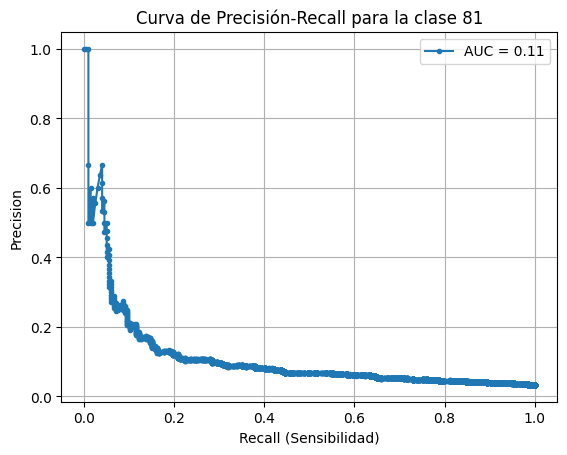

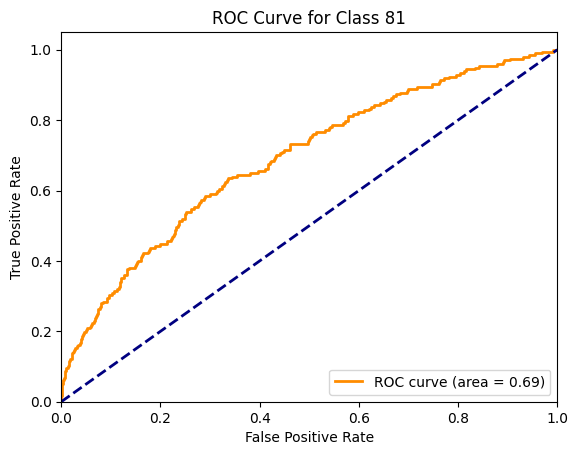

In [17]:

X = np.array(df_naics['embeddings'].tolist())
y = df_naics['81']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = LogisticRegression(class_weight='balanced',C=0.25, max_iter=1000)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
y_scores = model.predict_proba(X_test)[:, 1]  


f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')


conf_matrix = confusion_matrix(y_test, y_pred)
print('Matriz de Confusión:')
print(conf_matrix)

precision, recall, _ = precision_recall_curve(y_test, y_scores)
auc_score = auc(recall, precision)
print(f'AUC de la Curva de Precisión-Recall: {auc_score:.2f}')

plt.figure()
plt.plot(recall, precision, marker='.', label=f'AUC = {auc_score:.2f}')
plt.title('Curva de Precisión-Recall para la clase 81')
plt.xlabel('Recall (Sensibilidad)')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()


fpr, tpr, thresholds = roc_curve(y_test, y_scores)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Class 81')
plt.legend(loc="lower right")
plt.show()




SVM:

In [57]:
from sklearn.svm import SVC

# Convertir lista de listas a un array de NumPy para X
X = np.array(df_naics['embeddings'].tolist())
y = df_naics['32']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar un modelo SVM con balanceo de clase
model = SVC(kernel='linear',class_weight='balanced',C=0.2 ,probability=True)
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)
y_scores = model.predict_proba(X_test)[:, 1]  # probabilidades para la clase positiva

# Calcular el F1 score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

# Calcular y mostrar la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print('Matriz de Confusión:')
print(conf_matrix)

# Curva de Precisión-Recall y AUC
precision, recall, _ = precision_recall_curve(y_test, y_scores)
auc_score = auc(recall, precision)
print(f'AUC de la Curva de Precisión-Recall: {auc_score:.2f}')

plt.figure()
plt.plot(recall, precision, marker='.', label=f'AUC = {auc_score:.2f}')
plt.title('Curva de Precisión-Recall para la clase 32')
plt.xlabel('Recall (Sensibilidad)')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Calcular el AUC
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC para la clase 32')
plt.legend(loc="lower right")
plt.show()


RANDOM FOREST

F1 Score: 0.011695906432748537
Matriz de Confusión:
[[5761    4]
 [ 165    1]]
AUC de la Curva de Precisión-Recall: 0.10


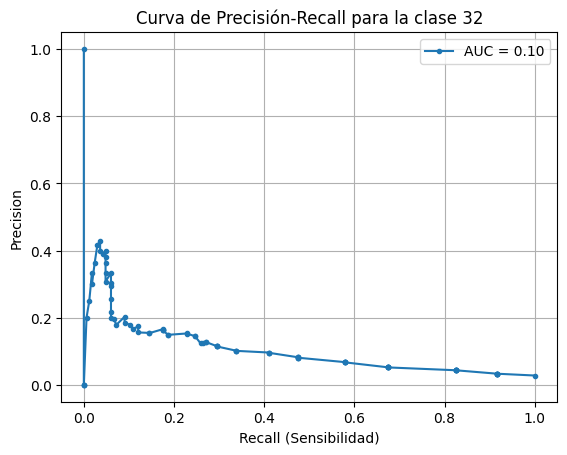

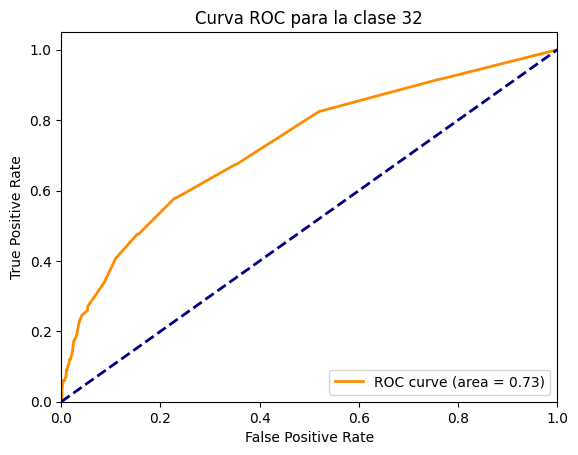

In [13]:
from sklearn.ensemble import RandomForestClassifier

# Convertir lista de listas a un array de NumPy para X
X = np.array(df_naics['embeddings'].tolist())
y = df_naics['32']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar un modelo Random Forest con balanceo de clase
model = RandomForestClassifier(class_weight='balanced')
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)
y_scores = model.predict_proba(X_test)[:, 1]  # probabilidades para la clase positiva

# Calcular el F1 score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

# Calcular y mostrar la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print('Matriz de Confusión:')
print(conf_matrix)

# Curva de Precisión-Recall y AUC
precision, recall, _ = precision_recall_curve(y_test, y_scores)
auc_score = auc(recall, precision)
print(f'AUC de la Curva de Precisión-Recall: {auc_score:.2f}')

plt.figure()
plt.plot(recall, precision, marker='.', label=f'AUC = {auc_score:.2f}')
plt.title('Curva de Precisión-Recall para la clase 32')
plt.xlabel('Recall (Sensibilidad)')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Calcular el AUC
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC para la clase 32')
plt.legend(loc="lower right")
plt.show()


GMB

F1 Score: 0.011111111111111112
Matriz de Confusión:
[[5752   13]
 [ 165    1]]
AUC de la Curva de Precisión-Recall: 0.08


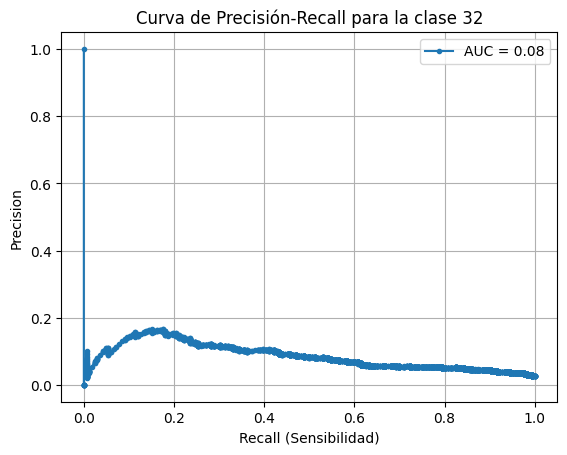

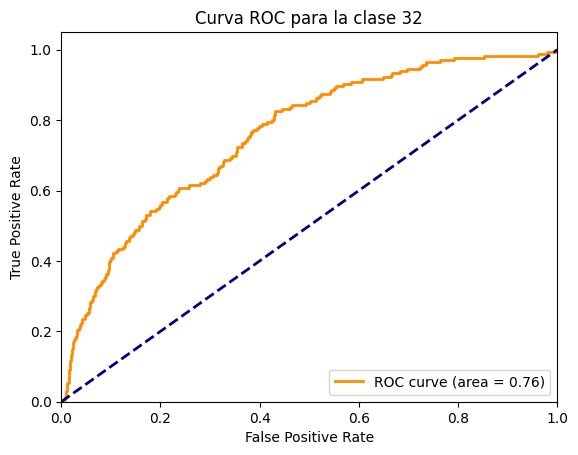

In [15]:
from sklearn.ensemble import GradientBoostingClassifier

# Convertir lista de listas a un array de NumPy para X
X = np.array(df_naics['embeddings'].tolist())
y = df_naics['32']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar un modelo Gradient Boosting Machine con balanceo de clase
model = GradientBoostingClassifier()
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)
y_scores = model.predict_proba(X_test)[:, 1]  # probabilidades para la clase positiva

# Calcular el F1 score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

# Calcular y mostrar la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print('Matriz de Confusión:')
print(conf_matrix)

# Curva de Precisión-Recall y AUC
precision, recall, _ = precision_recall_curve(y_test, y_scores)
auc_score = auc(recall, precision)
print(f'AUC de la Curva de Precisión-Recall: {auc_score:.2f}')

plt.figure()
plt.plot(recall, precision, marker='.', label=f'AUC = {auc_score:.2f}')
plt.title('Curva de Precisión-Recall para la clase 32')
plt.xlabel('Recall (Sensibilidad)')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Calcular el AUC
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC para la clase 32')
plt.legend(loc="lower right")
plt.show()


LightGBM

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 677, number of negative: 23043
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.131824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 23720, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028541 -> initscore=-3.527446
[LightGBM] [Info] Start training from score -3.527446
F1 Score: 0.0449438202247191
Matriz de Confusión:
[[5757    8]
 [ 162    4]]
AUC de la Curva de Precisión-Recall: 0.12


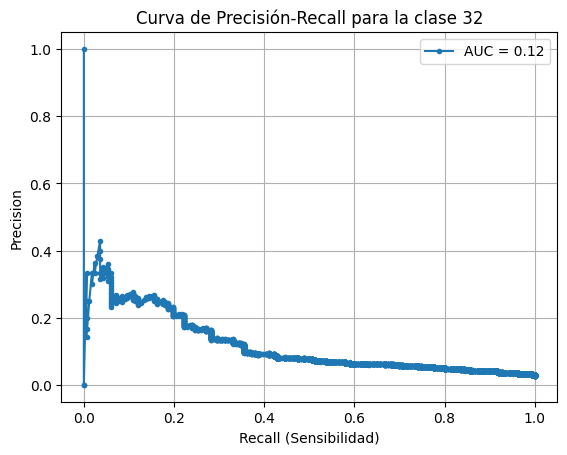

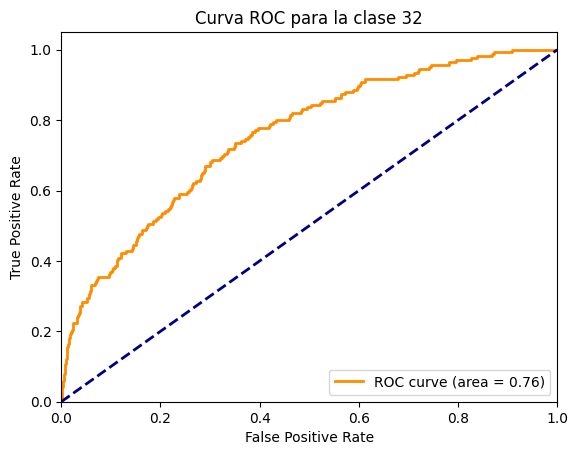

In [16]:
import lightgbm as lgb

# Convertir lista de listas a un array de NumPy para X
X = np.array(df_naics['embeddings'].tolist())
y = df_naics['32']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir los parámetros del modelo LightGBM
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting_type': 'gbdt',
    'class_weight': 'balanced'
}

# Crear un conjunto de datos LightGBM
train_data = lgb.Dataset(X_train, label=y_train)

# Entrenar el modelo LightGBM
num_round = 100
bst = lgb.train(params, train_data, num_round)

# Realizar predicciones en el conjunto de prueba
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)
y_pred_binary = np.round(y_pred)

# Calcular el F1 score
f1 = f1_score(y_test, y_pred_binary)
print(f'F1 Score: {f1}')

# Calcular y mostrar la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_binary)
print('Matriz de Confusión:')
print(conf_matrix)

# Curva de Precisión-Recall y AUC
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auc_score = auc(recall, precision)
print(f'AUC de la Curva de Precisión-Recall: {auc_score:.2f}')

plt.figure()
plt.plot(recall, precision, marker='.', label=f'AUC = {auc_score:.2f}')
plt.title('Curva de Precisión-Recall para la clase 32')
plt.xlabel('Recall (Sensibilidad)')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calcular el AUC
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC para la clase 32')
plt.legend(loc="lower right")
plt.show()


## ---------------------------------------------------------------------------------------------------------------------
## ---------------------------------------------------------------------------------------------------------------------
## ---------------------------------------------------------------------------------------------------------------------

In [2]:
ROUTE_BINARIZED_NAICS = '../src/data/BUENO_POR_FIN_2.csv'
df_naics = pd.read_csv(ROUTE_BINARIZED_NAICS)
print(df_naics.head())
print(f'Número inicial de filas: {df_naics.shape[0]}')
import ast
columns_to_check = df_naics.columns[df_naics.columns != 'embeddings']

# Contar el número de valores iguales a 1 en cada fila, excluyendo la columna de embeddings
row_counts = df_naics[columns_to_check].apply(lambda row: (row == 1).sum(), axis=1)

# Filtrar las filas donde el conteo de valores iguales a 1 sea mayor que 1
rows_with_more_than_one_one = df_naics[row_counts > 1]

# Imprimir el conteo de estas filas
print("Número de filas con más de un 1 en las columnas:")
print(rows_with_more_than_one_one.shape[0])

# Contamos la cantidad de '1's en todas las columnas
count_of_ones = df_naics.apply(lambda x: (x == 1).sum())
print(count_of_ones)

# Seleccionamos las columnas de clasificación
classification_columns = df_naics.columns.difference(['embeddings'])

# Contamos la cantidad de '1's en las columnas de clasificación para cada fila
df_naics['ones_count'] = df_naics[classification_columns].apply(lambda x: (x == 1).sum(), axis=1)

# Identificamos las filas con más de un '1' en las columnas de clasificación
rows_with_more_than_one = df_naics[df_naics['ones_count'] > 1]

# Seleccionamos aleatoriamente la mitad de estas filas para eliminarlas
rows_to_remove = rows_with_more_than_one.sample(frac=0.5, random_state=42)

# Eliminamos esas filas del DataFrame original
df_naics = df_naics.drop(rows_to_remove.index)

# Limpieza final
df_naics.drop('ones_count', axis=1, inplace=True)

print(f'Número de filas después de eliminar la mitad de las filas con más de un "1": {df_naics.shape[0]}')

# Recalculamos la cantidad de '1's para verificar
count_of_ones_after = df_naics.apply(lambda x: (x == 1).sum())
print(count_of_ones_after)

print("numero final de filas: ",df_naics.shape[0])

'''
classification_columns = df_naics.columns.difference(['embeddings'])


df_naics['ones_count'] = df_naics[classification_columns].apply(lambda x: (x == 1).sum(), axis=1)


df_naics = df_naics[df_naics['ones_count'] <= 1]

df_naics.drop('ones_count', axis=1, inplace=True)

print(df_naics.shape[0])

count_of_ones = df_naics.apply(lambda x: (x == 1).sum())
print(count_of_ones)
'''

   Unnamed: 0                                         embeddings  11  21  22  \
0           0  [0.3421159, 0.24559289, 0.003188484, -0.454343...   1   0   1   
1           1  [0.37763986, 0.31703675, 0.2015006, -0.1750039...   0   0   0   
2           2  [0.3418419, 0.19359905, 0.4428423, -0.11424164...   0   0   0   
3           3  [0.19853792, 0.14060616, 0.31806898, -0.309403...   0   0   0   
4           4  [0.36185867, 0.218326, 0.29591516, -0.23454015...   0   0   0   

   23  31  32  33  42  ...  53  54  55  56  61  62  71  72  81  92  
0   1   0   1   0   0  ...   0   0   0   1   0   0   0   0   0   0  
1   1   0   1   1   1  ...   0   0   0   0   0   0   0   0   0   0  
2   1   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   0  
3   1   0   0   0   0  ...   0   0   0   1   0   0   0   0   0   0  
4   1   0   0   1   1  ...   1   1   0   1   0   1   0   0   1   0  

[5 rows x 26 columns]
Número inicial de filas: 29651
Número de filas con más de un 1 en las columnas:
96

"\nclassification_columns = df_naics.columns.difference(['embeddings'])\n\n\ndf_naics['ones_count'] = df_naics[classification_columns].apply(lambda x: (x == 1).sum(), axis=1)\n\n\ndf_naics = df_naics[df_naics['ones_count'] <= 1]\n\ndf_naics.drop('ones_count', axis=1, inplace=True)\n\nprint(df_naics.shape[0])\n\ncount_of_ones = df_naics.apply(lambda x: (x == 1).sum())\nprint(count_of_ones)\n"

In [3]:
df_naics['embeddings'] = df_naics['embeddings'].apply(ast.literal_eval)

F1 Score: 0.2648845686512758
Matriz de Confusión:
[[4250  574]
 [  31  109]]
AUC de la Curva de Precisión-Recall: 0.48
ROC: 0.91


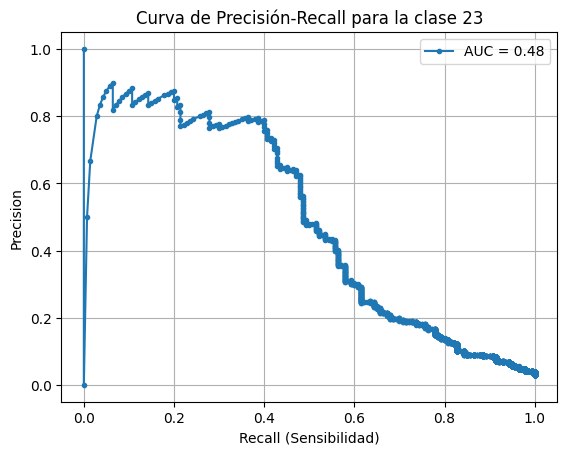

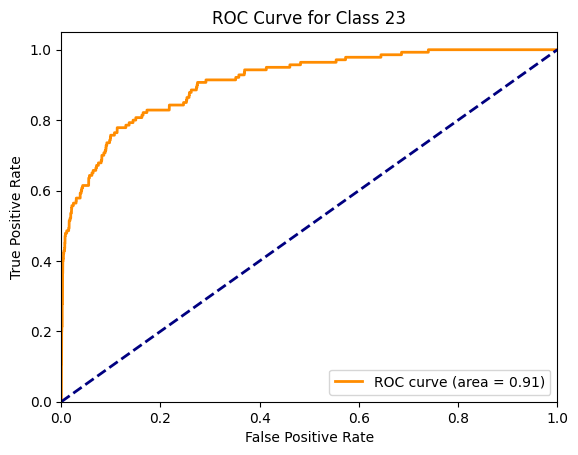

In [9]:

X = np.array(df_naics['embeddings'].tolist())
y = df_naics['22']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = LogisticRegression(class_weight='balanced',C=0.25, max_iter=1000)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
y_scores = model.predict_proba(X_test)[:, 1]  


f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')


conf_matrix = confusion_matrix(y_test, y_pred)
print('Matriz de Confusión:')
print(conf_matrix)


fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

precision, recall, _ = precision_recall_curve(y_test, y_scores)
auc_score = auc(recall, precision)
print(f'AUC de la Curva de Precisión-Recall: {auc_score:.2f}')
print(f'ROC: {roc_auc:.2f}')
plt.figure()
plt.plot(recall, precision, marker='.', label=f'AUC = {auc_score:.2f}')
plt.title('Curva de Precisión-Recall para la clase 23')
plt.xlabel('Recall (Sensibilidad)')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Class 23')
plt.legend(loc="lower right")
plt.show()




In [85]:


# Lista para almacenar los resultados
results = []

# Asumiendo que df_naics es tu DataFrame y ya está cargado
# Asumiendo que la columna de embeddings se llama 'embeddings'

# Obtener las columnas que no sean la columna de embeddings
columns_to_check = df_naics.columns[df_naics.columns != 'embeddings']

# Iterar sobre cada columna
for column in columns_to_check:
    X = np.array(df_naics['embeddings'].tolist())
    y = df_naics[column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Inicializar y ajustar el modelo de regresión logística
    model = LogisticRegression(class_weight='balanced', C=0.25, max_iter=1000)
    model.fit(X_train, y_train)

    # Predecir en el conjunto de prueba
    y_pred = model.predict(X_test)
    y_scores = model.predict_proba(X_test)[:, 1]

    # Calcular F1 Score
    f1 = f1_score(y_test, y_pred)

    # Calcular matriz de confusión
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Calcular Precisión-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    auc_score_pr = auc(recall, precision)

    # Calcular ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    auc_score_roc = auc(fpr, tpr)

    # Almacenar resultados
    results.append({'Column': column, 'F1 Score': f1, 'AUC Precision-Recall': auc_score_pr, 'AUC ROC': auc_score_roc})

    # Imprimir resultados
    print(f"Resultados para la columna '{column}':")
    print(f"F1 Score: {f1}")
    print("Matriz de Confusión:")
    print(conf_matrix)
    print(f"AUC de la Curva de Precisión-Recall: {auc_score_pr:.2f}")

    # Graficar Curva de Precisión-Recall
    plt.figure()
    plt.plot(recall, precision, marker='.', label=f'AUC PR = {auc_score_pr:.2f}')
    plt.title(f'Curva de Precisión-Recall para la clase {column}')
    plt.xlabel('Recall (Sensibilidad)')
    plt.ylabel('Precisión')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Graficar Curva ROC
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score_roc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Curva ROC para la clase {column}')
    plt.legend(loc="lower right")
    plt.show()

# Calcular la media de las métricas para todas las clases
mean_f1 = np.mean([result['F1 Score'] for result in results])
mean_auc_pr = np.mean([result['AUC Precision-Recall'] for result in results])
mean_auc_roc = np.mean([result['AUC ROC'] for result in results])

# Imprimir la media de las métricas
print(f"Media de F1 Score para todas las clases: {mean_f1:.2f}")
print(f"Media de AUC de la Curva de Precisión-Recall para todas las clases: {mean_auc_pr:.2f}")
print(f"Media de AUC de la Curva ROC para todas las clases: {mean_auc_roc:.2f}")


                                          embeddings  11  21  22  23  31  32  \
1  [0.37763986, 0.31703675, 0.2015006, -0.1750039...   0   0   0   1   0   1   
2  [0.3418419, 0.19359905, 0.4428423, -0.11424164...   0   0   0   1   0   0   
3  [0.19853792, 0.14060616, 0.31806898, -0.309403...   0   0   0   1   0   0   
5  [0.26641625, 0.24807568, 0.101800345, -0.45747...   0   0   0   1   0   0   
6  [0.25821352, 0.1080584, 0.36318278, -0.1448210...   0   0   0   0   0   0   

   33  42  44  ...  53  54  55  56  61  62  71  72  81  92  
1   1   1   0  ...   0   0   0   0   0   0   0   0   0   0  
2   0   0   0  ...   0   0   0   0   0   0   0   0   0   0  
3   0   0   0  ...   0   0   0   1   0   0   0   0   0   0  
5   1   0   0  ...   0   0   0   0   0   0   0   0   0   0  
6   0   0   0  ...   0   1   0   0   0   0   0   0   0   0  

[5 rows x 25 columns]
Training for 11
Unique values in 11: tensor([0., 1.])
Training for 21
Unique values in 21: tensor([0., 1.])
Training for 22
Unique

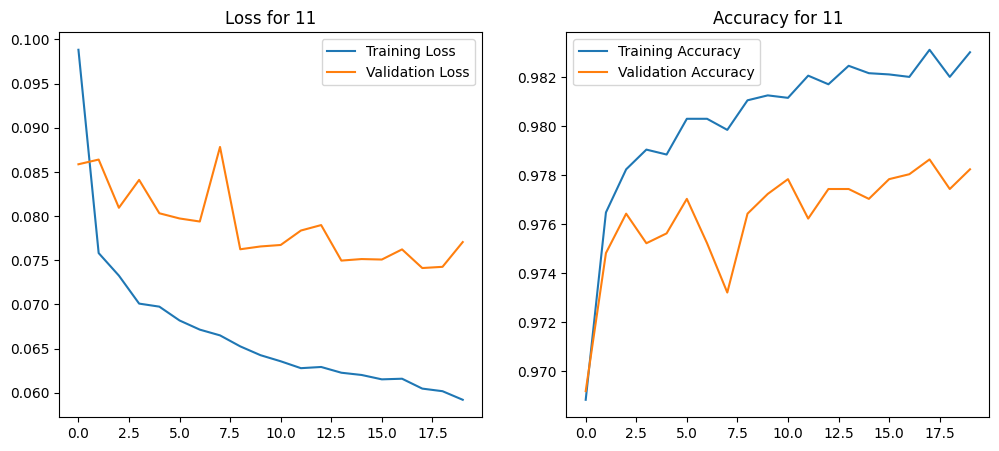

Training for 21
Validation Accuracy for 21: 0.9879


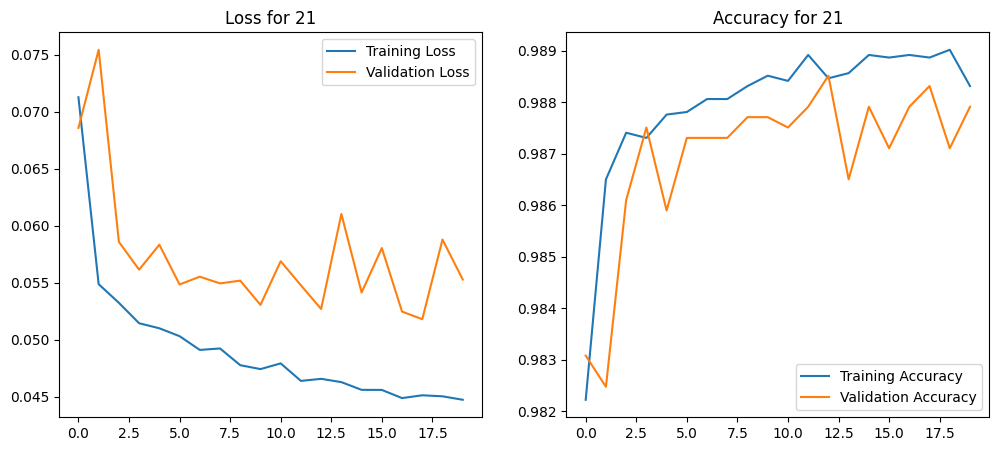

Training for 22
Validation Accuracy for 22: 0.9782


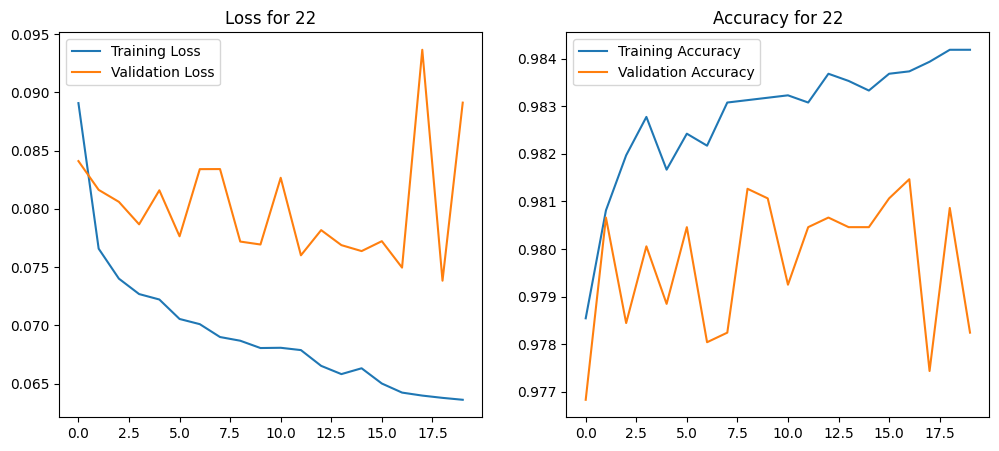

Training for 23
Validation Accuracy for 23: 0.8912


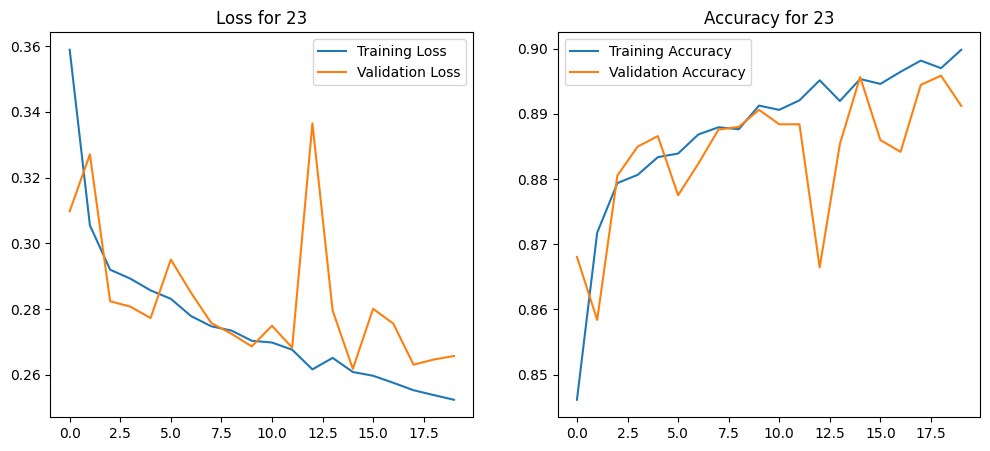

Training for 31
Validation Accuracy for 31: 0.9766


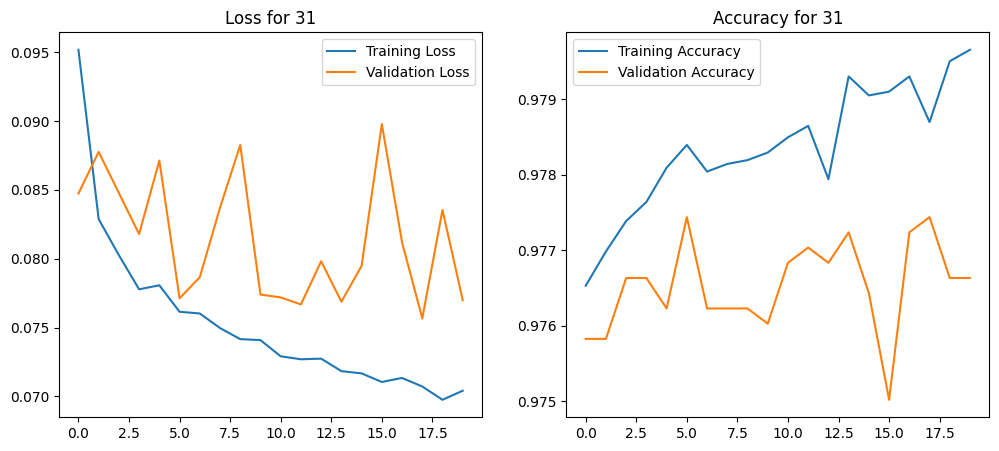

Training for 32
Validation Accuracy for 32: 0.9549


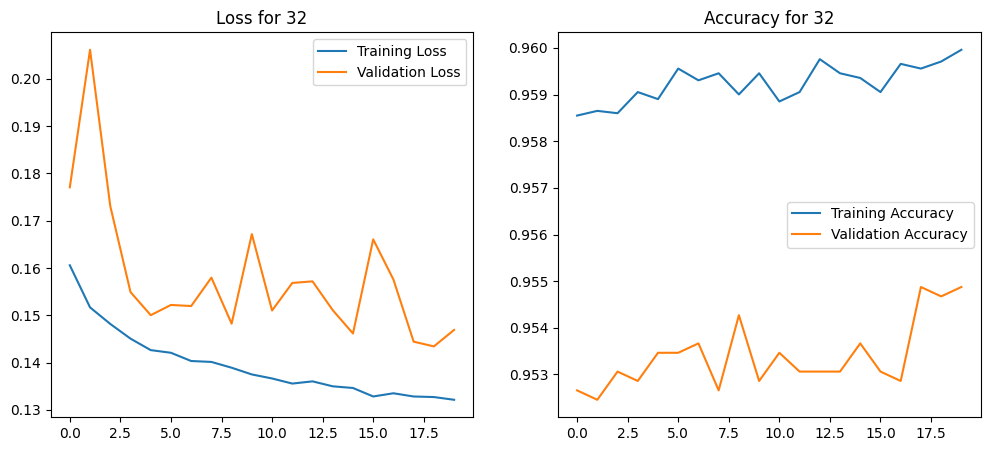

Training for 33


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
df_naics.drop('Unnamed: 0', axis=1, inplace=True)
print(df_naics.head())
class BinaryClassifier(nn.Module):
    def __init__(self, input_size):
        super(BinaryClassifier, self).__init__()
        self.layer1 = nn.Linear(input_size, 50)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(50, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.sigmoid(self.layer2(x))
        return x

def train_model(X_train, y_train, X_val, y_val, input_size, learning_rate=0.001, epochs=20):
    model = BinaryClassifier(input_size)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=10, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=10, shuffle=False)
    training_losses = []
    validation_losses = []
    training_accuracy = []
    validation_accuracy = []
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            predicted = outputs.squeeze().round()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        training_losses.append(total_loss / len(train_loader))
        training_accuracy.append(correct / total)
        model.eval()
        total_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels)
                total_loss += loss.item()
                predicted = outputs.squeeze().round()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        validation_losses.append(total_loss / len(val_loader))
        validation_accuracy.append(correct / total)
    return training_losses, validation_losses, training_accuracy, validation_accuracy

# Assume df_naics is your DataFrame
classification_targets = [col for col in df_naics.columns if col != 'embeddings']
for target in classification_targets:
    print(f"Training for {target}")
    X = torch.tensor(np.stack(df_naics['embeddings'].values), dtype=torch.float)
    y = torch.tensor(df_naics[target].values, dtype=torch.float)

    # Debugging: Check for any unexpected target values
    unique_targets = y.unique()
    print(f"Unique values in {target}: {unique_targets}")

    # Check if any values are not 0 or 1
    if not all((unique_targets == 0) | (unique_targets == 1)):
        print(f"Error: Non-binary values found in {target}")
        continue  # Skip this target or handle it appropriately

results = []
for target in classification_targets:
    print(f"Training for {target}")
    X = torch.tensor(np.stack(df_naics['embeddings'].values), dtype=torch.float)
    y = torch.tensor(df_naics[target].values, dtype=torch.float)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    tr_losses, val_losses, tr_acc, val_acc = train_model(X_train, y_train, X_val, y_val, X_train.shape[1])
    results.append({
        'target': target,
        'train_loss': tr_losses[-1],
        'val_loss': val_losses[-1],
        'train_acc': tr_acc[-1],
        'val_acc': val_acc[-1]
    })
    print(f'Validation Accuracy for {target}: {val_acc[-1]:.4f}')
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(tr_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'Loss for {target}')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(tr_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title(f'Accuracy for {target}')
    plt.legend()
    plt.show()

avg_train_loss = np.mean([res['train_loss'] for res in results])
avg_val_loss = np.mean([res['val_loss'] for res in results])
avg_train_acc = np.mean([res['train_acc'] for res in results])
avg_val_acc = np.mean([res['val_acc'] for res in results])

print("Average Training Loss: {:.4f}".format(avg_train_loss))
print("Average Validation Loss: {:.4f}".format(avg_val_loss))
print("Average Training Accuracy: {:.4f}".format(avg_train_acc))
print("Average Validation Accuracy: {:.4f}".format(avg_val_acc))


## --------

let's check where is data from

In [71]:
df_sbs= pd.read_csv('../src/data/sba_dataset.csv')
df_sbs_1= pd.read_csv('../src/data/SBS_Certified_Business_List.csv')
df_sbs_1 = df_sbs_1[['Business_Description', 'ID6_digit_NAICS_code','State']]
print(df_sbs.col)

def truncate_naics_codes(df: pd.DataFrame, digits: int) -> pd.DataFrame:
   
    if 'NAICS' in df.columns:
        df['NAICS'] = df['NAICS'].apply(
            lambda naics_list: [str(code).strip()[:digits] for code in naics_list]
        )
    return df


df_sbs_1 = df_sbs_1.rename(columns={'ID6_digit_NAICS_code': 'NAICS'})
df_sbs_1 = df_sbs_1.dropna()
print(df_sbs_1.columns)
df_sbs_1['NAICS'] = df_sbs_1['NAICS'].apply(lambda x: x if isinstance(x, list) else [x])


df_sbs_1=truncate_naics_codes(df_sbs_1,2)
print(df_sbs_1.head())
print("longitud df: ", df_sbs_1.shape[0])



states = df_sbs_1['State'].unique()

# Iterar sobre cada estado
for state in states:
    # Filtrar el DataFrame por el estado actual
    state_data = df_sbs_1[df_sbs_1['State'] == state]
    
    # Conteo de negocios por NAICS
    naics_counts = state_data['NAICS'].value_counts()
    
    # Calcular el total de negocios en el estado
    total_businesses = naics_counts.sum()
    
    # Imprimir el estado
    print(f"Estado: {state}")
    
    # Iterar sobre cada NAICS en el estado
    for naics, count in naics_counts.items():
        # Calcular el porcentaje de negocios por NAICS
        percentage = (count / total_businesses) * 100
        
        # Imprimir el número de negocios por NAICS y el porcentaje
        print(f"NAICS: {naics}, Negocios: {count}, Porcentaje: {percentage:.2f}%")
    
    print()

AttributeError: 'DataFrame' object has no attribute 'colummns'

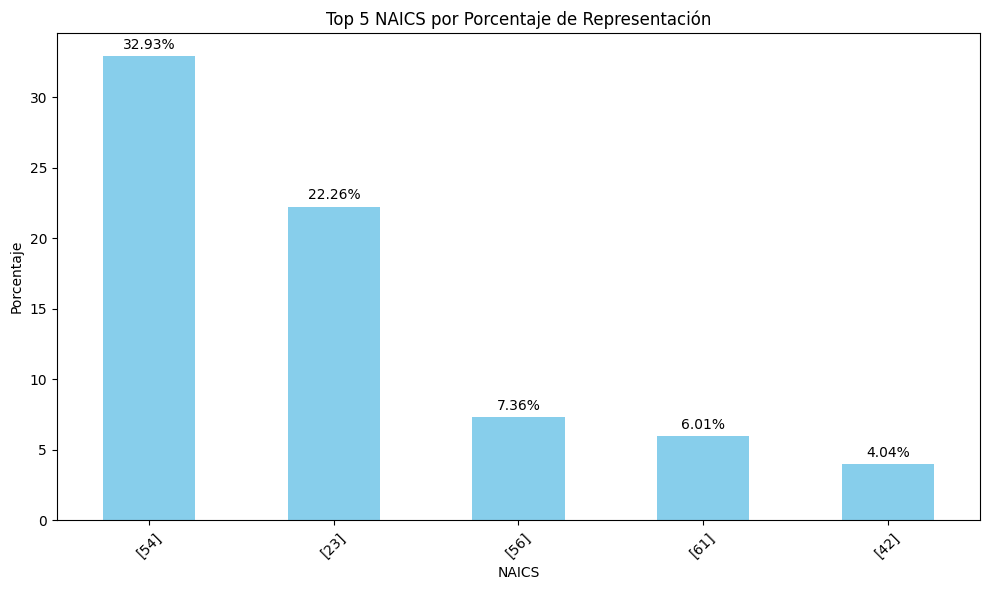

In [70]:
naics_counts = df_sbs_1['NAICS'].value_counts()

# Seleccionar los cinco NAICS principales
top_naics = naics_counts.head(5)

# Calcular el total de negocios en el DataFrame
total_businesses = naics_counts.sum()

# Calcular el porcentaje de representación para cada NAICS seleccionado
percentages = (top_naics / total_businesses) * 100

# Configurar el gráfico de barras
plt.figure(figsize=(10, 6))
percentages.plot(kind='bar', color='skyblue')
plt.title('Top 5 NAICS por Porcentaje de Representación')
plt.xlabel('NAICS')
plt.ylabel('Porcentaje')
plt.xticks(rotation=45)

# Anotar el porcentaje en cada barra
for i, percentage in enumerate(percentages):
    plt.text(i, percentage + 0.5, f"{percentage:.2f}%", ha='center')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

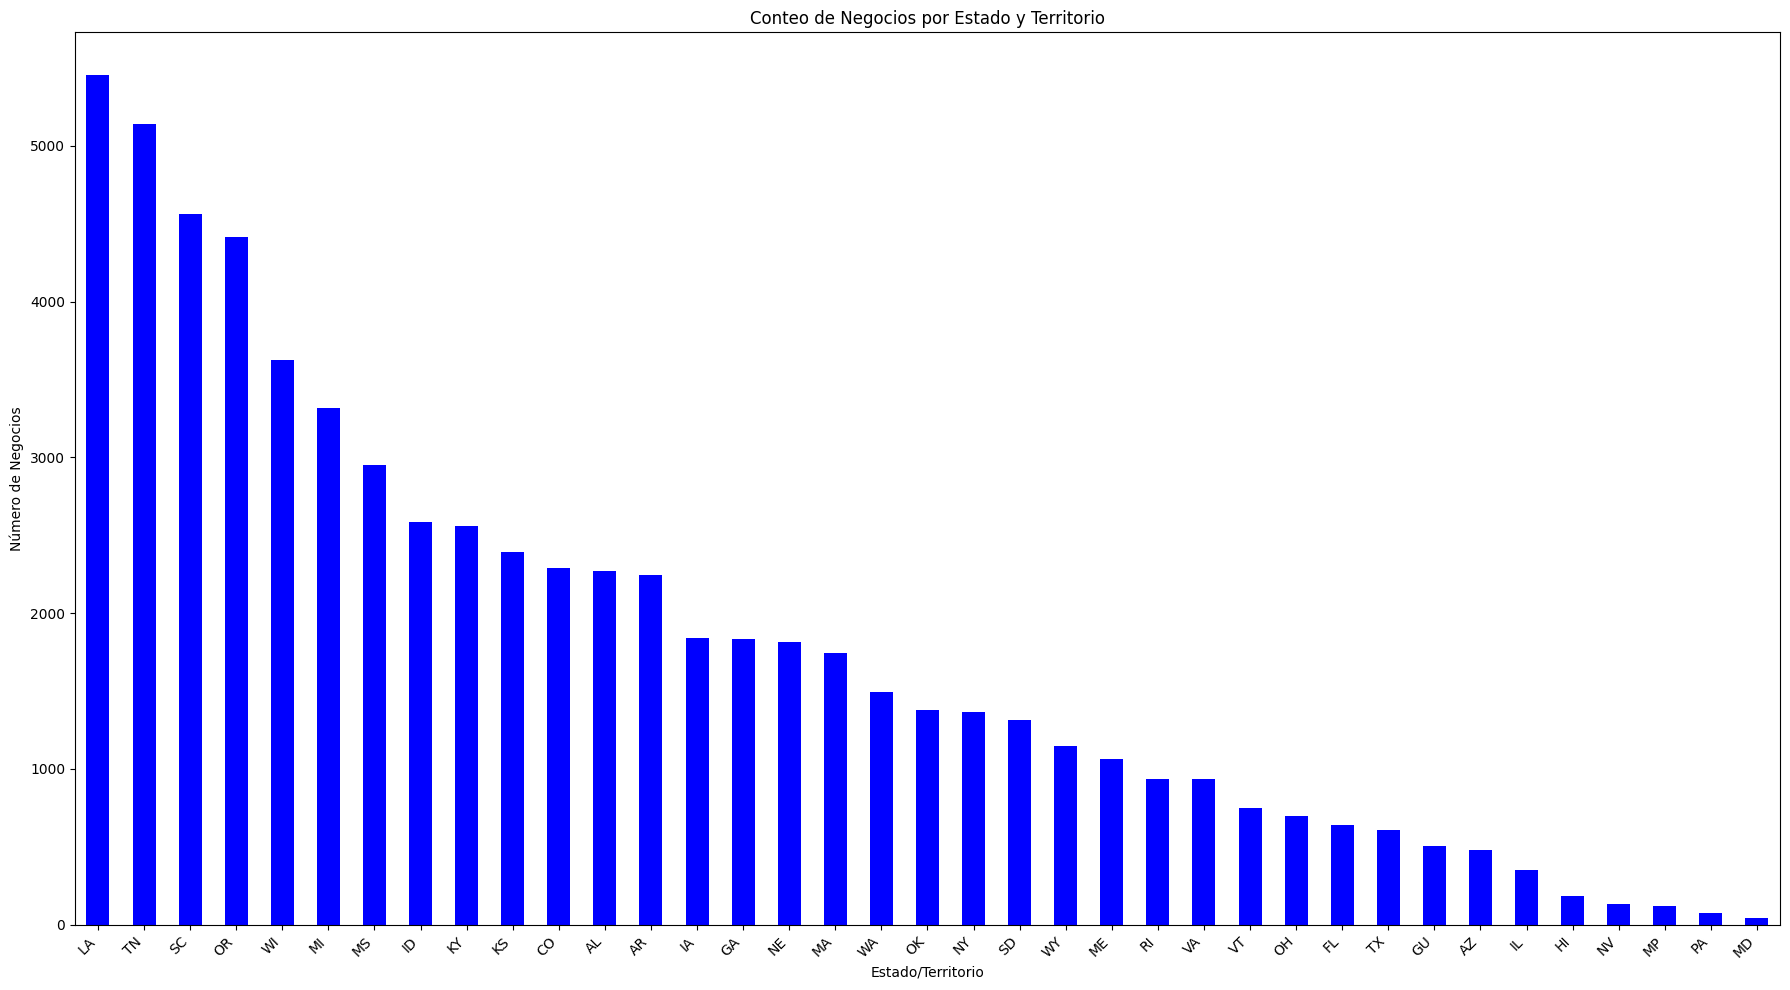

In [47]:
states_of_interest = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
                      'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD',
                      'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ',
                      'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC',
                      'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY',
                      'GU', 'MP']

# Filtrar filas donde 'FULL_ADDRESS' no es NaN
df_filtered = df_sbs[df_sbs['FULL_ADDRESS'].notna()]

# Extraer el estado de cada dirección
df_filtered['STATE'] = df_filtered['FULL_ADDRESS'].str.extract(r', (\w{2}) ')

# Filtrar filas donde 'STATE' está en la lista de interés
df_filtered = df_filtered[df_filtered['STATE'].isin(states_of_interest)]

# Contar cuántas veces aparece cada estado
state_counts = df_filtered['STATE'].value_counts()

# Configurar el gráfico de barras
plt.figure(figsize=(18, 10))  # Ajustar tamaño según necesidad
state_counts.plot(kind='bar', color='blue')  # Puedes cambiar el color según preferencias
plt.title('Conteo de Negocios por Estado y Territorio')
plt.xlabel('Estado/Territorio')
plt.ylabel('Número de Negocios')
plt.xticks(rotation=45, ha='right')  # Rotar etiquetas para mejor lectura

# Mostrar el gráfico
plt.tight_layout()
plt.show()